In [228]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import Datasets.ModelData as md
from session import *
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
from LR_Schedule.cos_anneal import CosAnneal
import matplotlib.pyplot as plt
import arff

In [229]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
idtohand = {0: "Nothing in hand; not a recognized poker hand",
            1: "One pair; one pair of equal ranks within five cards",
            2: "Two pairs; two pairs of equal ranks within five cards",
            3: "Three of a kind; three equal ranks within five cards",
            4: "Straight; five cards, sequentially ranked with no gaps",
            5: "Flush; five cards with the same suit",
            6: "Full house; pair + different rank three of a kind",
            7: "Four of a kind; four equal ranks within five cards",
            8: "Straight flush; straight + flush",
            9: "Royal flush; {Ace, King, Queen, Jack, Ten} + flush" }

num_classes = 10

idtosuit = {0: "Hearts", 1: "Spades", 2: "Diamonds", 3: "Clubs"}
idtorank = {0: "Ace", 
            1: "2", 
            2: "3", 
            3: "4", 
            4: "5", 
            5: "6", 
            6: "7", 
            7: "8", 
            8: "9", 
            9: "10", 
            10: "Jack", 
            11: "Queen", 
            12: "King"}

In [231]:
class PokerHandDataset(Dataset):
    def __init__(self, file, tfm=None, percentage=1, balanced=False):
        self.hands, self.labels = self.parse_csv(file, percentage)
        self.tfm = tfm
                  
        if balanced:
            counts = np.zeros(num_classes)

            for label in self.labels:
                counts[label] += 1

            class_weights = (len(self.labels) / counts)**.8
            
            fig, ax = plt.subplots()
            ax.bar(np.arange(len(counts)), counts)
            
            fig1, ax1 = plt.subplots()
            ax1.bar(np.arange(len(counts)), class_weights)
            
            fig2, ax2 = plt.subplots()
            ax2.bar(np.arange(len(counts)), [w * c for w, c in zip(class_weights, counts)])

            instance_weights = np.zeros(len(self.labels))

            for idx, label in enumerate(self.labels):
                instance_weights[idx] = class_weights[label]

            self.sampler = torch.utils.data.sampler.WeightedRandomSampler(instance_weights, len(instance_weights))
        else:
            self.sampler = None
       
    @staticmethod
    def parse_csv(file, percentage=1):
        df = pd.read_csv(file, header=None)
        xs = df[df.columns[0:10]]
        labels = np.array(df[df.columns[-1]])
        
        hands = []
        for hand in xs.values:
            hand = np.array(hand).reshape((5,2)) - 1
            hand = hand[hand[:,1].argsort()]
            hands.append(hand)
            
        hands = np.array(hands)
        
        if percentage < 1:
            idxs = np.random.choice(len(xs), int(len(xs) * percentage), replace=False)
            hands = hands[idxs]
            labels = labels[idxs]
            
        return hands, labels
        
    @staticmethod
    def make_tensor(hand):
        hand_tensor = torch.zeros((4,13)) - 1
        for card in hand:       
            hand_tensor[card[0], card[1]] = 1
        return hand_tensor.unsqueeze(0)
    
    @staticmethod
    def make_one_hot(label):
        tensor = torch.zeros(10)
        tensor[label] = 1
        return tensor
    
    def save_arff(self, file_name):
        data = np.concatenate((self.hands.reshape((-1, 10)), self.labels.reshape(-1, 1)), 1)
        
        cols = ["SuitCard1", "RankCard1", 
                "SuitCard2", "RankCard2", 
                "SuitCard3", "RankCard3", 
                "SuitCard4", "RankCard4",
                "SuitCard5", "RankCard5",
                "Hand"]

        df = pd.DataFrame(data, columns=cols)

        arff.dump(file_name, df.values, names=df.columns)
        
    
    def __len__(self): return len(self.hands)

    def __getitem__(self, i):
        hand, label = self.hands[i], self.labels[i]
        x, y = self.make_tensor(hand), label
        
        if self.tfm is not None:
            x = self.tfm.transform_x(x)
            
        return x, y

In [232]:
class SuitShiftTransform():
    def transform_x(self, hand):
        return hand[:,torch.randperm(4)]

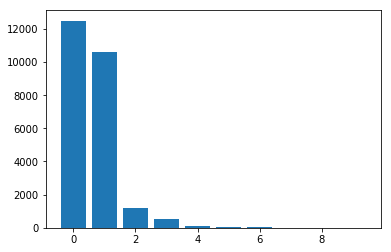

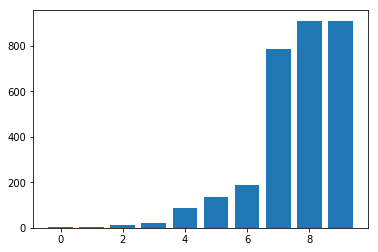

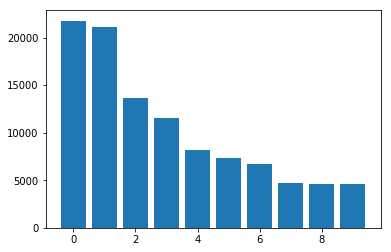

In [233]:
data_path = Path("./Datasets/PokerHands")
train_dataset = PokerHandDataset(data_path/'training.csv', tfm=SuitShiftTransform(), balanced=True)
val_dataset = PokerHandDataset(data_path/'testing.csv', percentage=.05)
test_dataset = PokerHandDataset(data_path/'testing.csv')

In [234]:
# train_dataset.save_arff('./Datasets/PokerHands/training_sorted.arff')
# test_dataset.save_arff('./Datasets/PokerHands/testing_sorted.arff')

In [235]:
data = md.ModelData({'train': train_dataset}, 32)
val_data = md.ModelData({'val': val_dataset, 'test': test_dataset}, 256)

In [236]:
class Network(nn.Module):
    def __init__(self):
        super().__init__();
        self.conv1 = nn.Conv2d(1, 32, (4,1))       
        self.conv2 = nn.Conv2d(1, 32, (1,13))
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=.1)
        self.fc = nn.Linear(32*4 + 32*13, 64)
        self.relu2 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout(p=.1)
        self.fc2 = nn.Linear(64, num_classes)      
        
    def forward(self, x, log=False):
        x_1 = self.conv1(x)
        x_2 = self.conv2(x)
        x = torch.cat([x_1.view(x_1.size(0), -1), x_2.view(x_2.size(0), -1)], dim=1)
        x = self.drop(x)
        x = self.relu(x)
        if log: print(x[0])
        x = self.fc(x)
        # x = self.drop2(x)
        x = self.relu2(x)
        if log: print(x[0])
        x = self.fc2(x)
        if log: print(x[0])
        return x

In [237]:
model = Network()

In [238]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, label):
        weight = self.get_weight(pred, label)
        return F.binary_cross_entropy_with_logits(pred, label, weight)
    
    def get_weight(self, x, t):
        alpha, gamma = 0.25, 2
        p = x
        pt = p * t + (1-p) * (1-t)
        w = alpha * t + (1-alpha) * (1-t)
        return w * (1-pt).pow(gamma)

In [239]:
class PokerHandAccuracy(_AccuracyMeter):
    def __init__(self):
        self.reset()
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]

    def reset(self):
        self.num_correct = 0
        self.count = 0
        self.confusion = [[0 for y in range(num_classes)] for x in range(num_classes)]
        
    def accuracy(self): 
        return self.num_correct / self.count

    def update(self, actn, label, log=False):   
        actn = F.log_softmax(actn, dim=1)
        # if log: print("Actn : ", outputs)
        vals, preds = torch.max(actn, 1)
        # preds = preds + 1
        if log: print("Max  :", preds)
        # bgs = vals < .7
        # if log: print("BGS  : ", bgs)
        # preds[bgs] = 0
        if log: print("Preds: ", preds)    
        if log: print("GT   : ", label)
        self.num_correct += torch.sum(preds == label).item()
        if log: print("Num Correct: ", self.num_correct)
        self.count += label.shape[0]
        
        for lab, pred in zip(label, preds):
            self.confusion[lab][pred] += 1
            
    def plot_confusion_matrix(self,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        cm = np.array(self.confusion)
        fig, ax = plt.subplots(figsize=(12,12))
        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar(img, ax=ax)
        ax.set_title(title)
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

In [240]:
criterion = nn.CrossEntropyLoss()
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, 1e-2)

In [241]:
x, y = next(iter(data['train']))
x[0]

tensor([[[-1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.]]])

In [242]:
actn = Network.forward(model, x, log=True)
actn

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1022, 0.0000, 0.2556, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6296, 0.6296, 0.6296, 0.6296, 0.0000,
        0.0000, 0.6296, 0.4242, 0.9024, 0.6296, 0.9024, 0.6296, 0.6296, 0.7413,
        0.7413, 0.7413, 0.7413, 0.7413, 0.0000, 0.7413, 0.1862, 0.4045, 0.7413,
        0.4045, 0.7413, 0.7413, 0.0000, 1.3583, 1.3583, 1.3583, 1.3583, 0.0000,
        0.0000, 0.5051, 0.6572, 0.0000, 0.6572, 1.3583, 1.3583, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0689, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1954, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4057, 0.4057, 0.4057,
        0.4057, 0.0000, 0.0000, 0.4057, 0.6842, 0.0000, 0.0000, 0.0000, 0.4057,
        0.4057, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3884,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5509, 0.5509, 0.5509, 0.5509,
        0.5509, 0.0000, 0.0000, 0.0994, 

tensor([[-0.1601, -0.0841,  0.0486,  0.0266,  0.0600, -0.0186, -0.0856, -0.0276,
         -0.1704, -0.1147],
        [-0.3176, -0.2153, -0.0016,  0.0019, -0.2813,  0.0019, -0.0153, -0.0795,
         -0.1133, -0.0051],
        [-0.3613, -0.1517, -0.0422,  0.0061, -0.0218, -0.0042, -0.0446,  0.1267,
         -0.2019, -0.0712],
        [-0.3375, -0.1494, -0.1445,  0.0526, -0.0137, -0.0100, -0.0227,  0.0378,
         -0.0860, -0.1265],
        [-0.1971, -0.1203, -0.0353,  0.0833, -0.1533, -0.0412, -0.0051,  0.0082,
         -0.2014, -0.0580],
        [-0.3468, -0.1711,  0.0197, -0.0485, -0.0455,  0.0049, -0.0542,  0.0980,
         -0.1203, -0.0147],
        [-0.3725, -0.2258,  0.0285,  0.1435, -0.2310,  0.0192,  0.0933,  0.0525,
         -0.1616, -0.0561],
        [-0.3345, -0.1156,  0.0558,  0.0751, -0.0911, -0.0618, -0.0357,  0.0098,
         -0.2040, -0.1668],
        [-0.3845, -0.2200,  0.0296,  0.0810, -0.0668, -0.0754, -0.0456,  0.0313,
         -0.3076, -0.0541],
        [-0.3213, -

In [243]:
accuracy = PokerHandAccuracy()
accuracy.update(actn, y, log=True)

Max  : tensor([4, 3, 7, 3, 3, 7, 3, 3, 3, 2, 5, 3, 3, 5, 3, 3, 6, 7, 7, 5, 3, 3, 6, 3,
        3, 3, 5, 3, 3, 3, 7, 5])
Preds:  tensor([4, 3, 7, 3, 3, 7, 3, 3, 3, 2, 5, 3, 3, 5, 3, 3, 6, 7, 7, 5, 3, 3, 6, 3,
        3, 3, 5, 3, 3, 3, 7, 5])
GT   :  tensor([1, 0, 0, 2, 0, 2, 0, 2, 8, 0, 2, 0, 0, 6, 1, 5, 9, 1, 1, 5, 8, 7, 9, 7,
        2, 7, 0, 4, 0, 9, 4, 8])
Num Correct:  1


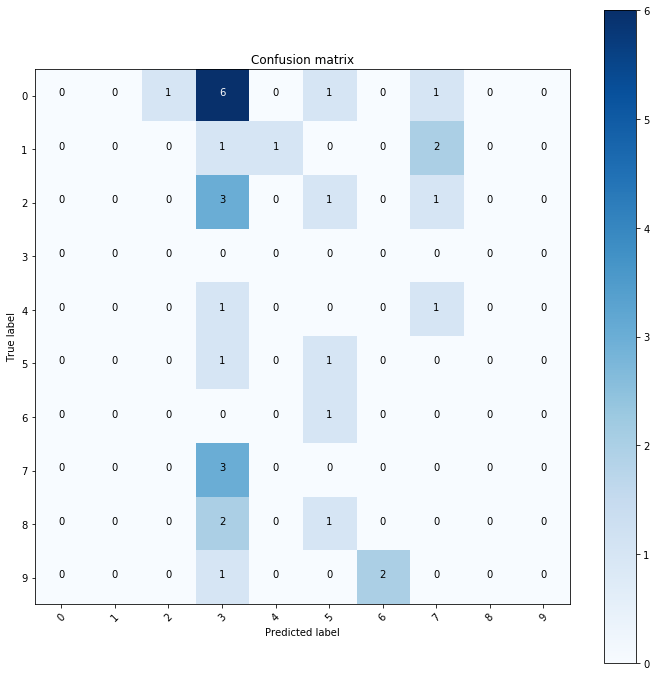

In [244]:
accuracy.plot_confusion_matrix()

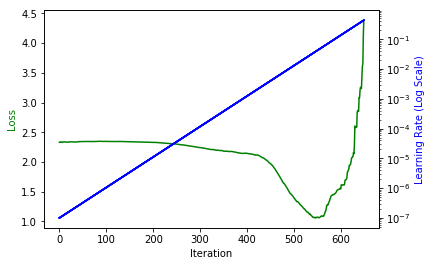

In [245]:
lr_find(sess, data['train'], start_lr=1e-7)

In [246]:
sess.set_lr(1e-2)

In [247]:
accuracy = PokerHandAccuracy()
validator = Validator(val_data['val'], accuracy)
lr_schedule = CosAnneal(len(data['train']), lr_min=1e-5, T_mult=2)
schedule = TrainingSchedule(data['train'], [lr_schedule, validator])

In [248]:
sess.train(schedule, 31)

Training Loss: 0.220870  Validaton Loss: 0.116019 Validation Accuracy: 0.978460


Training Loss: 0.084020  Validaton Loss: 0.026777 Validation Accuracy: 0.992760


Training Loss: 0.044699  Validaton Loss: 0.023687 Validation Accuracy: 0.993000


Training Loss: 0.048102  Validaton Loss: 0.032780 Validation Accuracy: 0.989220


Training Loss: 0.035561  Validaton Loss: 0.014531 Validation Accuracy: 0.995780


Training Loss: 0.017456  Validaton Loss: 0.015125 Validation Accuracy: 0.995060


Training Loss: 0.017464  Validaton Loss: 0.011644 Validation Accuracy: 0.996740


Training Loss: 0.054212  Validaton Loss: 0.056693 Validation Accuracy: 0.982620


Training Loss: 0.037123  Validaton Loss: 0.009002 Validation Accuracy: 0.998340


Training Loss: 0.017853  Validaton Loss: 0.012511 Validation Accuracy: 0.997040


Training Loss: 0.019899  Validaton Loss: 0.008274 Validation Accuracy: 0.998600


Training Loss: 0.015910  Validaton Loss: 0.008324 Validation Accuracy: 0.998680


Training Loss: 0.006686  Validaton Loss: 0.006914 Validation Accuracy: 0.999220


Training Loss: 0.004899  Validaton Loss: 0.008829 Validation Accuracy: 0.998380


Training Loss: 0.004361  Validaton Loss: 0.008423 Validation Accuracy: 0.998680


Training Loss: 0.025051  Validaton Loss: 0.017408 Validation Accuracy: 0.995560


Training Loss: 0.033876  Validaton Loss: 0.012924 Validation Accuracy: 0.996980


Training Loss: 0.016911  Validaton Loss: 0.012330 Validation Accuracy: 0.996680


Training Loss: 0.029654  Validaton Loss: 0.052836 Validation Accuracy: 0.987620


Training Loss: 0.009640  Validaton Loss: 0.009082 Validation Accuracy: 0.998200


Training Loss: 0.013514  Validaton Loss: 0.005941 Validation Accuracy: 0.999480


Training Loss: 0.014939  Validaton Loss: 0.006869 Validation Accuracy: 0.999120


Training Loss: 0.007490  Validaton Loss: 0.009427 Validation Accuracy: 0.998180


Training Loss: 0.009123  Validaton Loss: 0.008535 Validation Accuracy: 0.998740


Training Loss: 0.005377  Validaton Loss: 0.005883 Validation Accuracy: 0.999580


Training Loss: 0.005456  Validaton Loss: 0.007957 Validation Accuracy: 0.998660


Training Loss: 0.007181  Validaton Loss: 0.005629 Validation Accuracy: 0.999760


Training Loss: 0.003476  Validaton Loss: 0.005928 Validation Accuracy: 0.999800


Training Loss: 0.003976  Validaton Loss: 0.005646 Validation Accuracy: 0.999760


Training Loss: 0.002823  Validaton Loss: 0.005621 Validation Accuracy: 0.999840


Training Loss: 0.002198  Validaton Loss: 0.005639 Validation Accuracy: 0.999840


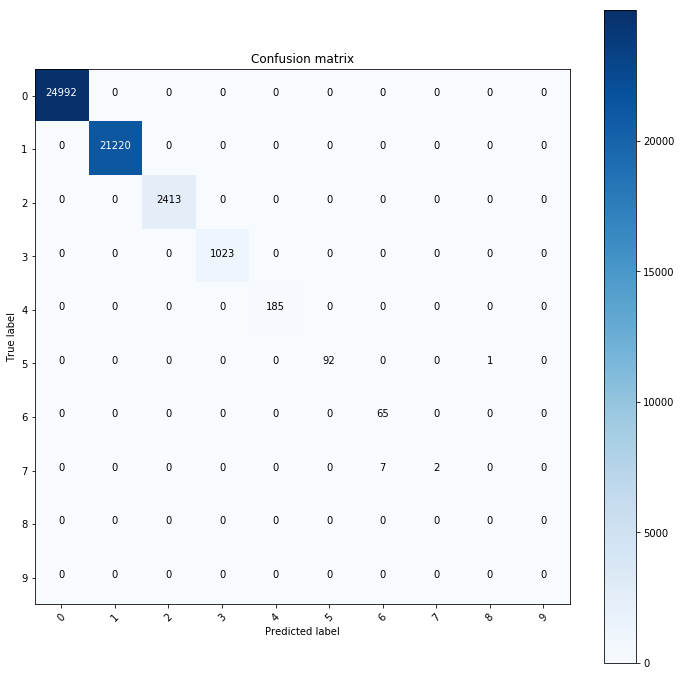

In [249]:
accuracy.plot_confusion_matrix()

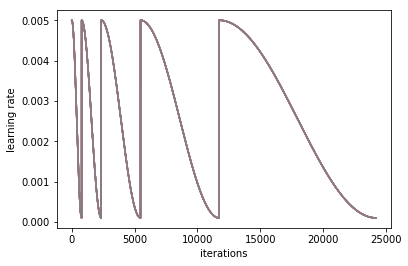

In [250]:
lr_schedule.plot()

In [253]:
sess.save("PokerHand-99.99")

Training Loss: 0.000000  Validaton Loss: 0.000109 Validation Accuracy: 1.000000


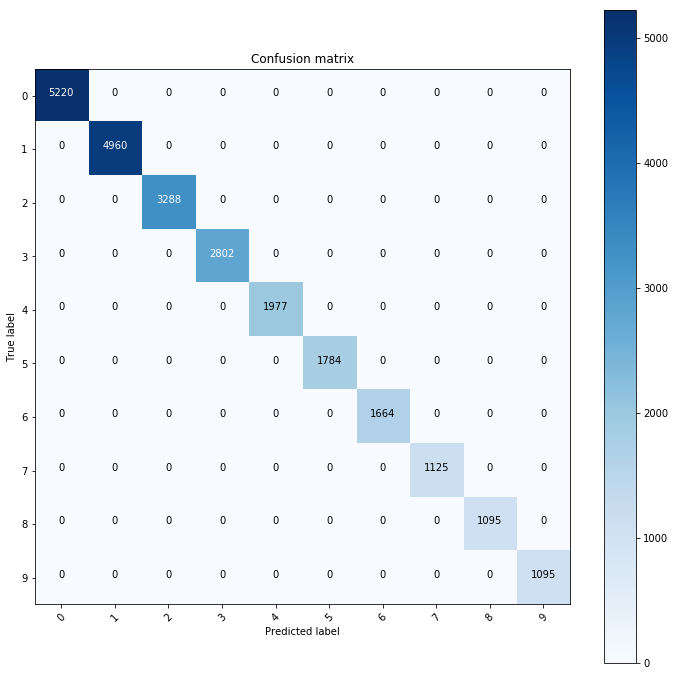

In [251]:
t_accuracy = PokerHandAccuracy()
t_validator = Validator(data['train'], t_accuracy)
t_validator.on_epoch_end(sess, LossMeter())
t_accuracy.plot_confusion_matrix()

Training Loss: 0.000000  Validaton Loss: 0.007629 Validation Accuracy: 0.999789


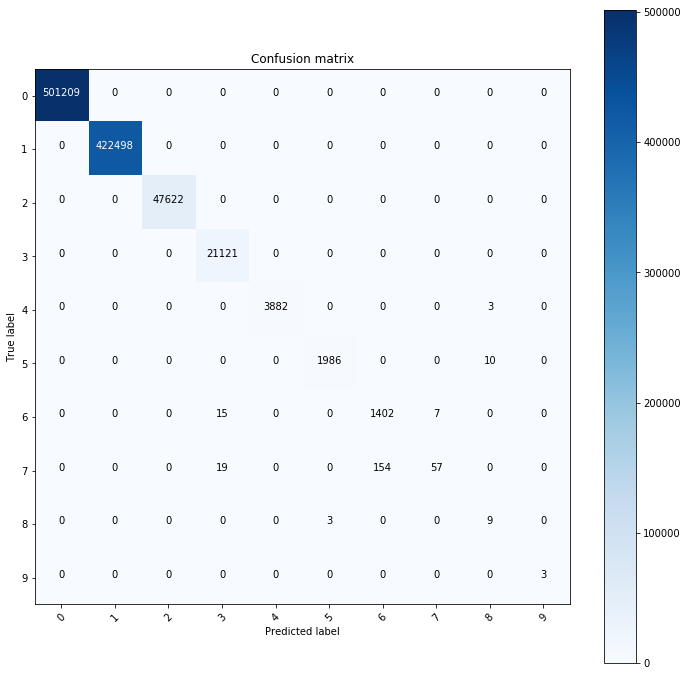

In [252]:
t_accuracy = PokerHandAccuracy()
t_validator = Validator(val_data['test'], t_accuracy)
t_validator.on_epoch_end(sess, LossMeter())
t_accuracy.plot_confusion_matrix()

In [ ]:
len(data['train'])

In [ ]:
len(data['test'])